In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import time

warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

In [4]:
# loading data
X_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_balanced.npy"
)
y_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_balanced.npy"
)
X_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)

##  XGBoost with Hyperparameter Tuning


In [5]:
param_grid = {
    # Tree structure
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    # Learning
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "gamma": [0, 0.1, 0.2],
    # Regularization
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0.1, 1, 10],
}


In [ ]:
# Initialize base XGBoost
xgb_base = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss",
    verbosity=0,
)

In [ ]:
# Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

In [8]:
start_time = time.time()
xgb_random.fit(X_train_balanced, y_train_balanced)
search_time = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, 

In [10]:
xgb_best = xgb_random.best_estimator_
print(xgb_best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=3, ...)


## Model Evaluation on Test Set

In [11]:
# Predictions
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)

In [12]:
# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average=None, zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average=None, zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average=None, zero_division=0)

precision_macro_xgb = precision_score(
    y_test, y_pred_xgb, average="macro", zero_division=0
)
recall_macro_xgb = recall_score(y_test, y_pred_xgb, average="macro", zero_division=0)
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average="macro", zero_division=0)

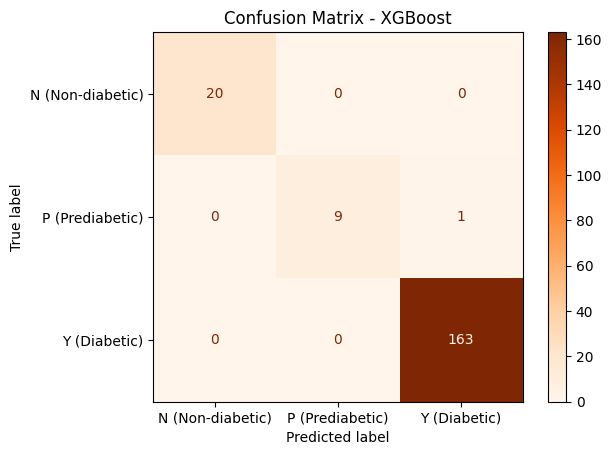

In [13]:
class_names = ["N (Non-diabetic)", "P (Prediabetic)", "Y (Diabetic)"]

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=class_names)
disp.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix - XGBoost")
plt.show()

           Feature  Importance
3            HbA1c    0.676007
9              BMI    0.096882
0              AGE    0.072941
5               TG    0.039850
4             Chol    0.037580
7              LDL    0.017657
1             Urea    0.017241
8             VLDL    0.014411
6              HDL    0.012111
10  Gender_encoded    0.007723
2               Cr    0.007596


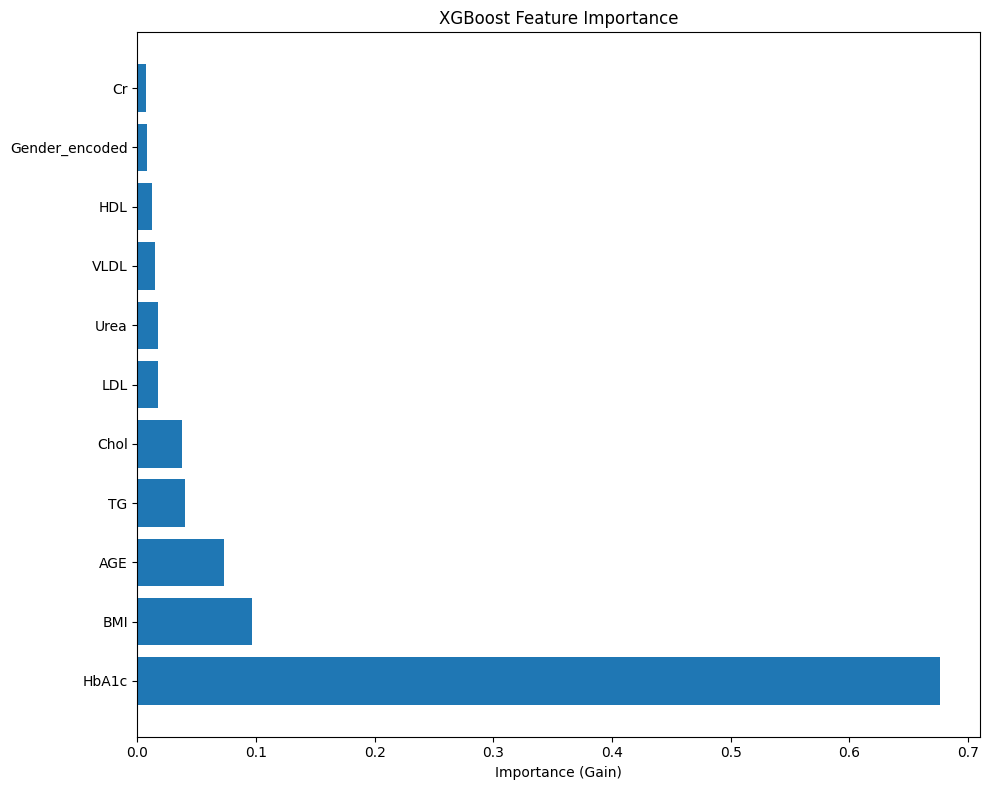

In [14]:
feature_names = X_test.columns.tolist()

importances = xgb_best.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print(importance_df)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance (Gain)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()